# Анализ бизнес-показателей. Юнит-экономика.

#### Наша задача - проанализировать эффективность рекламной кампании приложения Procrastinate Pro+. Выявить  причины возникновения убытков, а также дать рекомендации по исправлению ситуации. 

*В нашем распоряжении данные о посещениях и сессиях пользователей, их покупках и рекламных расходах.*

Импортируем необходимые библиотеки и загрузим имеющиеся данные:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits, orders, costs = (
pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'),
pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'),
pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'),
)

Получим информацию о данных:

In [3]:
visits.info()
orders.info()
costs.info()                     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Видим, что в пропусках данных нет, но с такими названиями столбцов работать будет неудобно. Преобразуем названия столбцов, убрав заглавные буквы и заменив пробелы на нижнее подчёркивание: 

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower()

Также преобразуем даты в формат datetime:

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

На всякий случай проверим на дубликаты:

In [6]:
visits.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
costs.duplicated().sum()

0

Дубликатов нет. Проверим еще соответствие уникальных названий каналов в соответствующих таблицах, так как по этим столбцам нам нужно будет объединять таблицы: 

In [9]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [10]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

**Теперь всё в порядке и  данные подготовлены к анализу.**

**Зададим необходимые для анализа функции:**

Функция для создания профилей пользователей:

In [11]:
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

Функция для подсчёта Retention Rate

In [12]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time 

Функция для подсчёта конверсии

In [13]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time 

Функция для подсчёта LTV, CAC, ROI

In [14]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функция сглаживания

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации Retention Rate

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Функция для визуализации LTV и ROI

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Необходимые функции заданы. Сможем использовать их для оптимизации процесса анализа данных.**

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


#### С помощью ранее созданной функции получим таблицу с профилями пользователей:

In [19]:
profiles = get_profiles(visits, orders, costs)

In [20]:
profiles.head(5)

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

#### Узнаем период анализа, определив минимальную и максимальную дату начала пользовательских сессий: 

In [21]:
min_date, max_date = profiles['dt'].min(), profiles['dt'].max()

In [22]:
print('Минимальная дата привлечения пользователей: ', min_date)
print('Максимальная дата привлечения пользователей: ', max_date)

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


*Итак, у нас есть статистика по сессиям пользователей в период с 1 мая по 27 октября 2019 года*

#### Посмотрим, пользователи из  каких стран пользуются приложением и какова доля платящих пользователей в каждой стране:

In [23]:
users_region = (profiles.pivot_table(index='region',values='payer',aggfunc=['count', 'sum', 'mean']).reset_index()
                .rename(columns={'region':'Регион','count':'Пользователи', 'sum':'Платящие пользователи' , 'mean': '% Платящих пользователей'})
                .droplevel(1, axis=1)
                .sort_values(by='% Платящих пользователей', ascending=False)
                .style.format({'% Платящих пользователей':'{:.2%}'}))
users_region

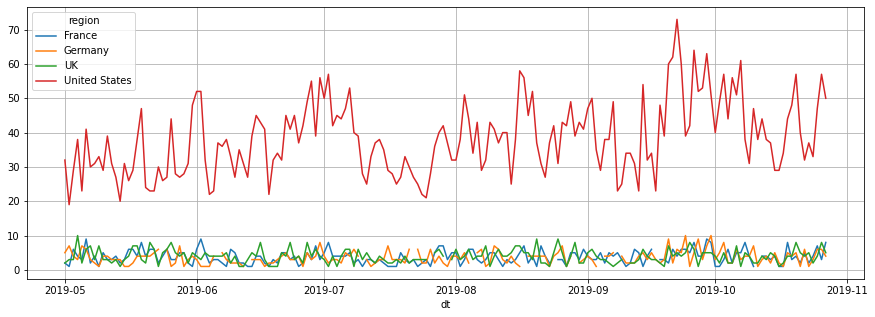

In [24]:
profiles.query('payer == True').pivot_table(
    index='dt', 
    columns='region', 
    values='user_id', 
    aggfunc='nunique'  
).plot(figsize=(15, 5), grid=True)

plt.show()

*По таблице и графику видим, что наибольшее число пользователей приходит в приложение из США, при этом процент платищих пользователей у США также самый высокий (почти 7%). При этом мы видим, что, несмотря на то что общее число пользователей из Германии наименьшее, процент привлеченных платящих пользователей второй после США (около 4%). Показатели Франции и Великобритании сопоставимые.*  

#### Посмотрим, с каких устройств заходят пользователи в приложение и какими устройствами пользуются платящие пользователи:

In [25]:
users_device = (profiles.pivot_table(index='device',values='payer',aggfunc=['count', 'sum', 'mean']).reset_index()
                .rename(columns={'device':'Устройство','count':'Пользователи', 'sum':'Платящие пользователи' , 'mean': '% Платящих пользователей'})
                .droplevel(1, axis=1)
                .sort_values(by='% Платящих пользователей', ascending=False)
                .style.format({'% Платящих пользователей':'{:.2%}'}))
users_device

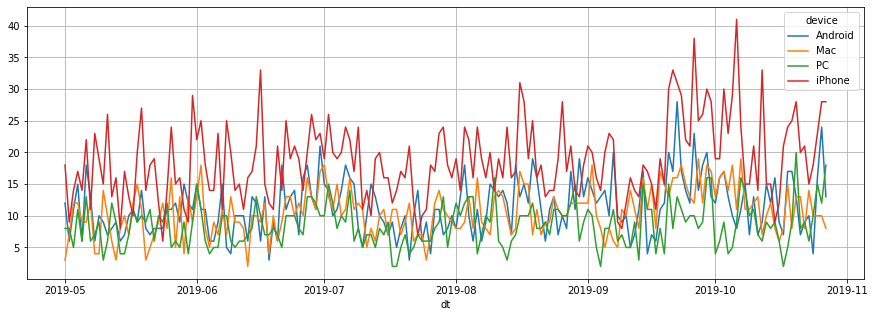

In [26]:
profiles.query('payer == True').pivot_table(
    index='dt', 
    columns='device', 
    values='user_id', 
    aggfunc='nunique'  
).plot(figsize=(15, 5), grid=True)

plt.show()

*В данном случае можем обратить внимание, что наибольший процент платящих пользователей приходит с устройств Mac и IPhone (более 6% от общего количества приходящих с этих устройств пользователей). Однако можем отметить, что в количественном выражение всех привлеченных пользоватлей - наибольшее с IPhone, наименьшее - с PC.*  

#### Изучим рекламные источники и посмотрим, какие каналы привлекли больше всего платных пользователей:

In [27]:
users_channel = (profiles.pivot_table(index='channel',values='payer',aggfunc=['count', 'sum', 'mean']).reset_index()
                .rename(columns={'channel':'Канал','count':'Пользователи', 'sum':'Платящие пользователи' , 'mean': '% Платящих пользователей'})
                .droplevel(1, axis=1)
                .sort_values(by='% Платящих пользователей', ascending=False)
                .style.format({'% Платящих пользователей':'{:.2%}'}))
users_channel

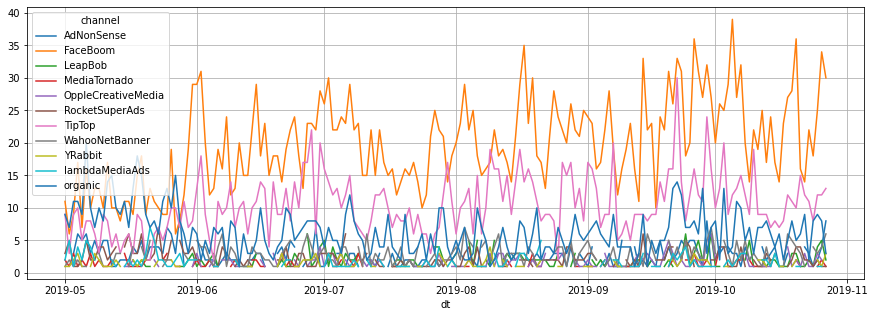

In [28]:
profiles.query('payer == True').pivot_table(
    index='dt', 
    columns='channel', 
    values='user_id', 
    aggfunc='nunique'  
).plot(figsize=(15, 5), grid=True)

plt.show()

*Мы видим, что наибольшее количество пользователей пришли через канал Organic, то есть без рекламы, однако и доля платящих пользователей, пришедших из этого канала наименьшая. Посредством рекламы больше всего пользователей пришло через  FaceBoom, при этом и доля платящих пользователей, привлеченных в этом канале наибольшая (чуть больше 12%).   Также можно отметить каналы  lambdaMediaAds и TipTop, которые также привлекли большое количество платных пользователей. Имеет хороший процент по привлечению платных пользователей и канал AdNonSense, однако общее количество привлеченных через него пользователей сравнительно небольшое (менее 4000). С другой стороны канал OppleCreativeMedia привлек более 8,5 тысяч пользователей, но при этом процент платящих самый низкий среди рекламных каналов (менее 3%).* 

**Таким образом, можем отметить, что наибольшее количество платных пользователей привлекаются через канал Faceboom с Iphone в США.** 

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитаем общую сумму расходов на  маркетинг за заданный период:

In [29]:
round(costs['costs'].sum(),2)

105497.3

*Итак, за данный период на продвижение потратили ~ 105 тыс 497 долларов.*

#### Посмотрим как распределялся этот маркетинговый бюджет по каналам.

In [30]:
acquisition = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index().rename(columns={'channel':'Канал','costs':'Расходы, $'})
acquisition['Расходы, %'] = acquisition['Расходы, $']/acquisition['Расходы, $'].sum()
acquisition.style.format({'Расходы, %':'{:.2%}'})

*Обратим внимание, что более 50% маркетинга было потрачено на канал TipTop (странно, ведь мы выяснили, что он не является лидером по привлечению платных пользователей). На Faceboom потратили 30% бюджета (выглядит обосновано, так как этот канал привлек больше всех платных польователей).*

#### Посмотрим как менялись расходы на маркетинг на протяжении заданного периода:

*Оценим изменения в расходах на маркетинг в разрезе месяцев и недель по каждому каналу, для этого добавим соответствующие столбцы в таблицу:*

In [31]:
costs['month'] = pd.DatetimeIndex(costs['dt']).month 
costs['week'] = pd.DatetimeIndex(costs['dt']).week 

/tmp/ipykernel_317/133455302.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  costs['week'] = pd.DatetimeIndex(costs['dt']).week


*Построим графики изменения расходов для каждого канала по неделям и месяцам:*

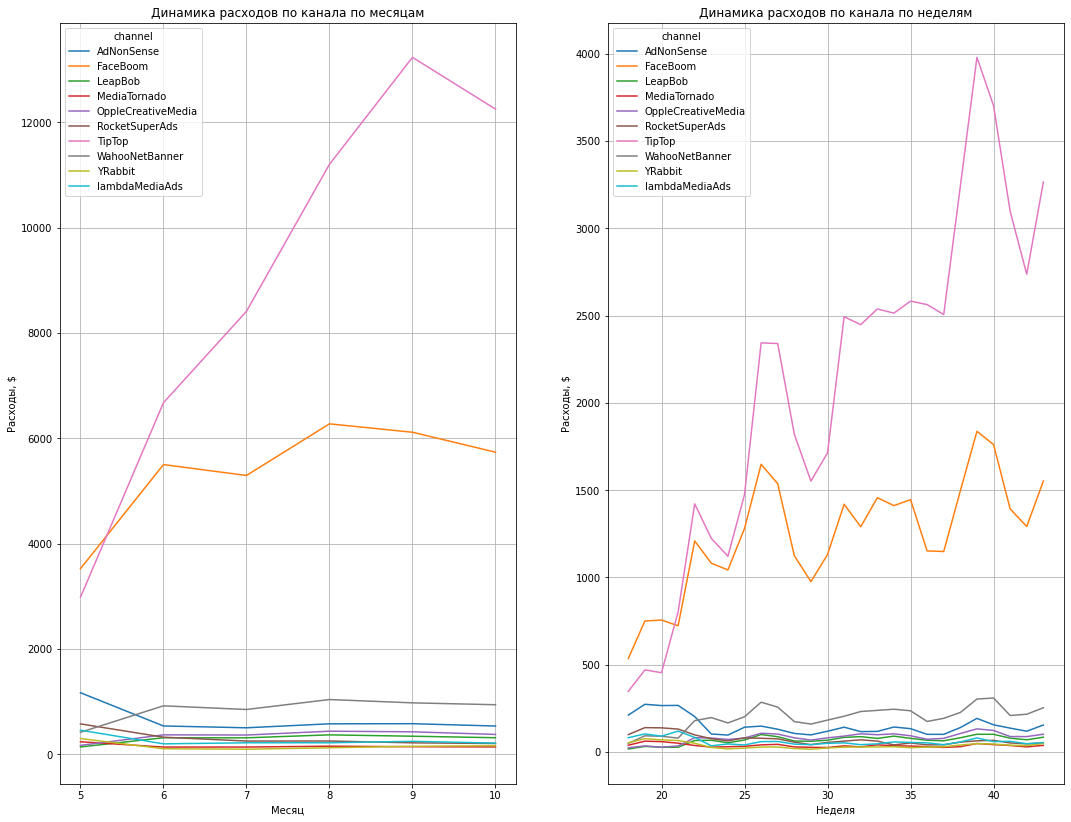

In [32]:
costs.pivot_table(
    index='month',  
    columns='channel', 
    values='costs',
    aggfunc='sum' 
).plot(figsize=(18, 14), grid=True, ax=plt.subplot(1, 2, 1), title='Динамика расходов по канала по месяцам', ylabel='Расходы, $', xlabel='Месяц')
costs.pivot_table(
    index='week',  
    columns='channel',  
    values='costs',  
    aggfunc='sum'  
).plot(figsize=(18, 14), grid=True,ax=plt.subplot(1, 2, 2), title='Динамика расходов по канала по неделям', ylabel='Расходы, $', xlabel='Неделя') 
plt.show()

*Можем обратить внимание, что расходы на некоторые каналы были резко сокращены в июне (например,YRabbit, AdNonSense и lamdaMediaAds), а на другие наоборот увеличены (например FaceBoom, OpleCreativeMedia, LeapBob) - возможно каким-то образом ратировали эти каналы в связи с коректировкой маркетинговой стратегии или по каким-то еще причинам изменили приоритеты. Также обращают на себя внимание графики каналов TipTop и FaceBoom, расходы на которые растут до сентября/августа соответственно и значительно превосходят расходы на другие каналы.* 

#### Проверим, во сколько в среднем обошлось привлечение пользователя из каждого источника:

*Узнаем среднюю стоимость привлечения пользователя в каждом платном канале и построим график изменения САС:*

In [33]:
profiles_ad = profiles.query('channel != "organic"') #исключим из анализа бесплатный канал

In [34]:
profiles_ad.pivot_table(
    index='channel',values='acquisition_cost', aggfunc='mean').reset_index()\
    .rename(columns={'channel':'Канал', 'acquisition_cost':'Средняя стоимость пользователя, $'})\
    .sort_values(by='Средняя стоимость пользователя, $', ascending=False).reset_index(drop=True).style.format({'Средняя стоимость пользователя, $':'{:.2}'})

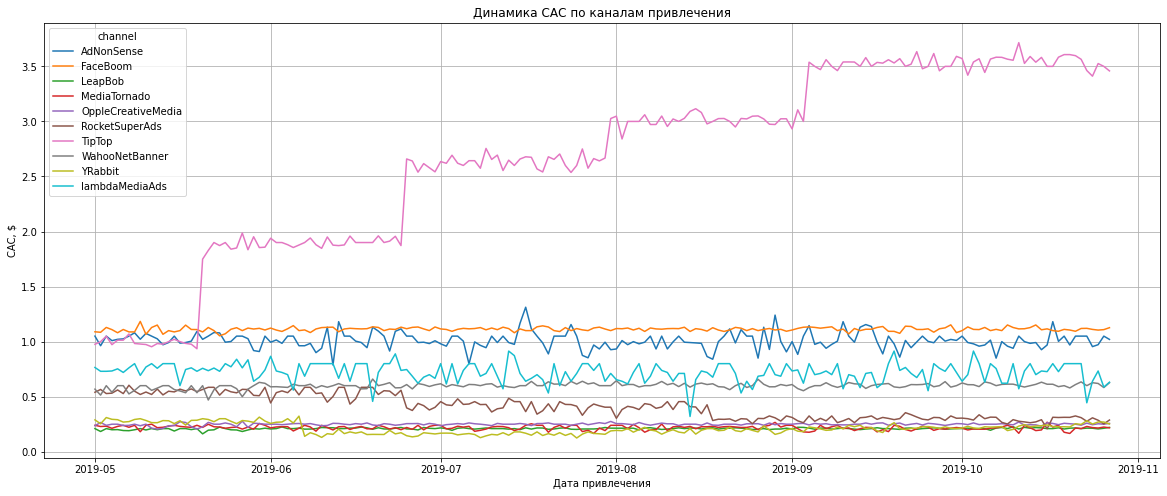

In [35]:
profiles_ad.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

*Здесь также обращаем внимание на канал TipTop средняя стоимость привлечения пользователя в котором в разы больше, чем в остальных, кроме того она выроссла более чем в 3 раза по сравнению с началом периода. Можно также отметить, что на втором месте по стоимости пользователя идет канал Faceboom, однако она чуть больше 1$ и крайне стабильна на протяжении всего периода.* 

**Отметили аномальный рост расходов на канал TipTop и его высокую стоимость в пересчете на одного привлеченного пользователя по сравнению с остальными каналами. Возможно расходы на этот канал продвижения стоит пересмотреть. Обратим на него внимание при анализе окупаемости.**

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Посмотрим на общую окупаемость рекламы по всем источникам:

*Для этого определим момент и горизонт анализа:* 

In [36]:
observation_date = max_date
horizon = 14

*Получим показатели LTV, ROI и СAC, исключив канал "organic" и посмотрим на их динамику на графиках:* 

In [37]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False,
)

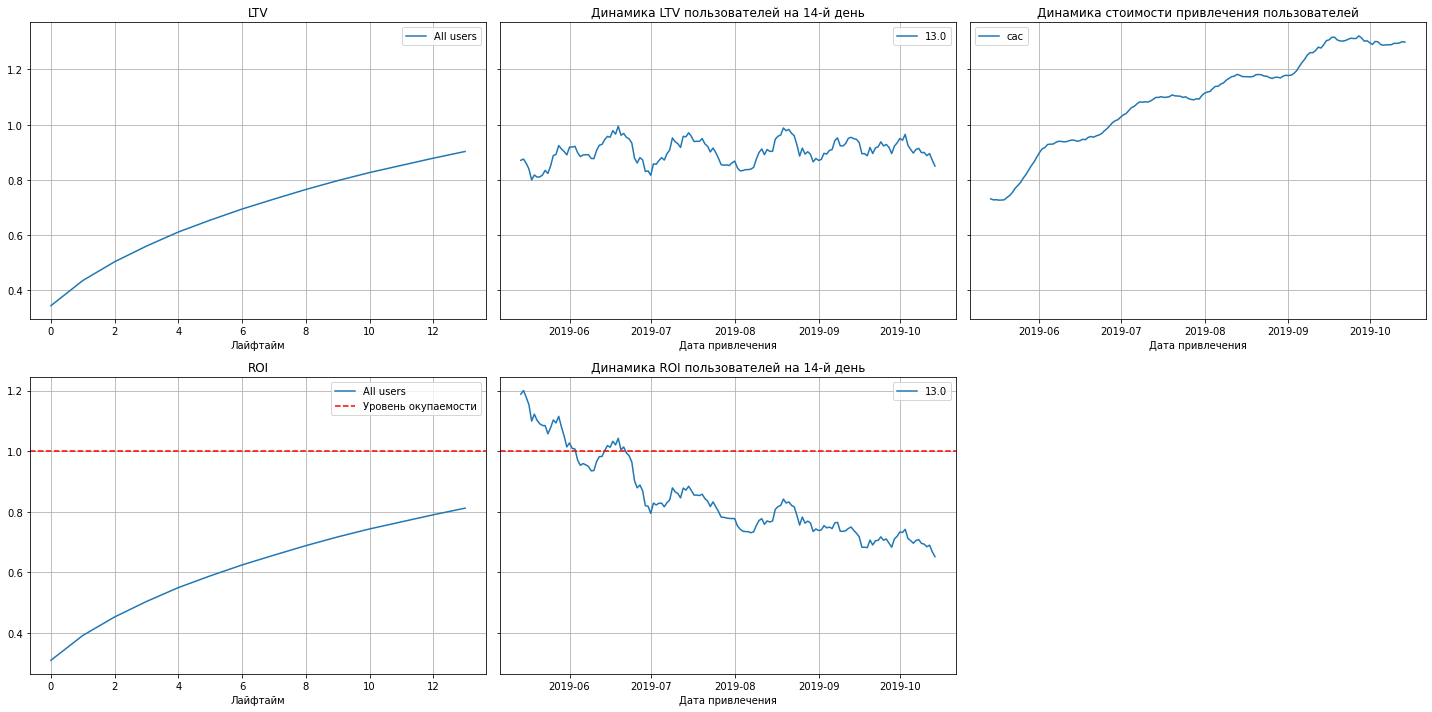

In [38]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*По графикам видим, что реклама не окупается. САС значительно растет на протяжении всего периода. При этом можно отметить, что при пиковом росте САС в конце мая-начале июня LTV также показывает пик роста, с другой стороны в этот же период ROI максимально снижается.
Это может подверждать наше предположение в предыдущем пункте о том, что расходы на некоторые каналы продвижения 
стоит пересмотреть.*

#### Посмотрим на динамику конверсии пользователей:

In [66]:
result_raw, conversion, conversion_history = get_conversion(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False,
)

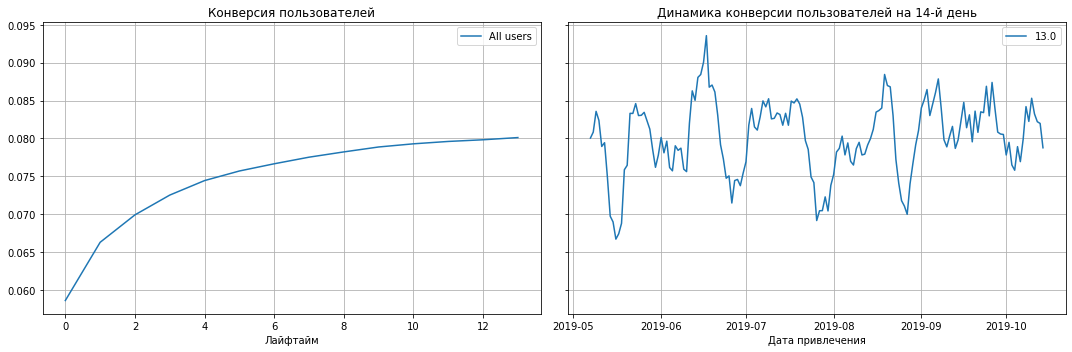

In [67]:
plot_conversion(conversion, conversion_history, horizon, window=7)

*С конверсией в целом все выглядит неплохо (есть резкие спады в определенные периоды, но это может быть связано с сезонностью или другими факторами).*

#### Посмотрим на конверсию в разрезе каналов продвижения:

In [68]:
result_raw, conversion, conversion_history = get_conversion(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False,
)

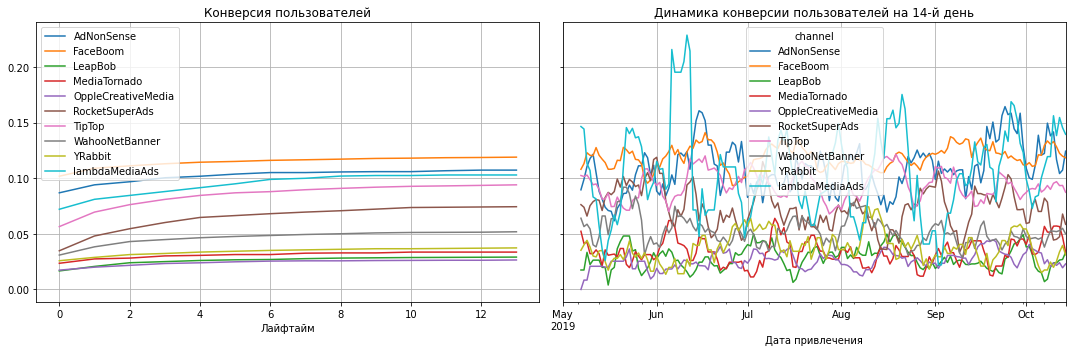

In [69]:
plot_conversion(conversion, conversion_history, horizon, window=7)

*Видим, что лучше других конвертируются в платящих пользователи через каналы FaceBoom, AdNonSense и  LamdaMediaAds.*

#### Посмотрим на конверсию в разрезе устройств:

In [70]:
result_raw, conversion, conversion_history = get_conversion(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False,
)

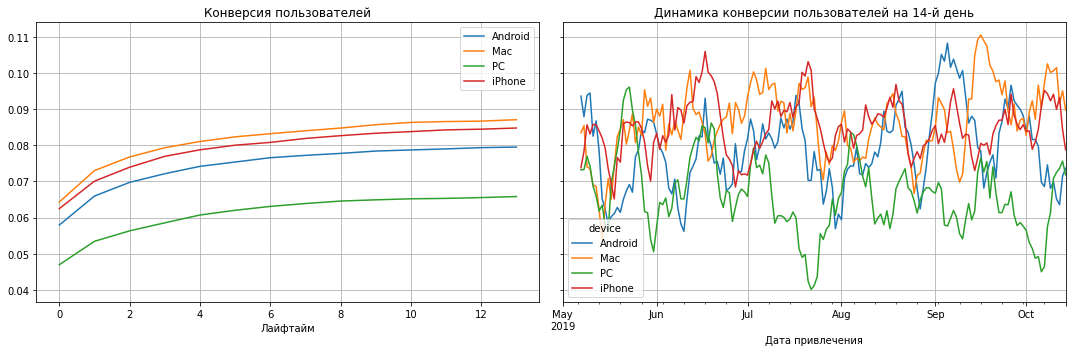

In [71]:
plot_conversion(conversion, conversion_history, horizon, window=7)

*Лучшая конверсия у устройств  Mac и IPhone, при этом значительно хуже других конвертируются пользователи PC.*

#### Посмотрим также на коверсию в регионах:

In [72]:
result_raw, conversion, conversion_history = get_conversion(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['region'],
    ignore_horizon=False,
)

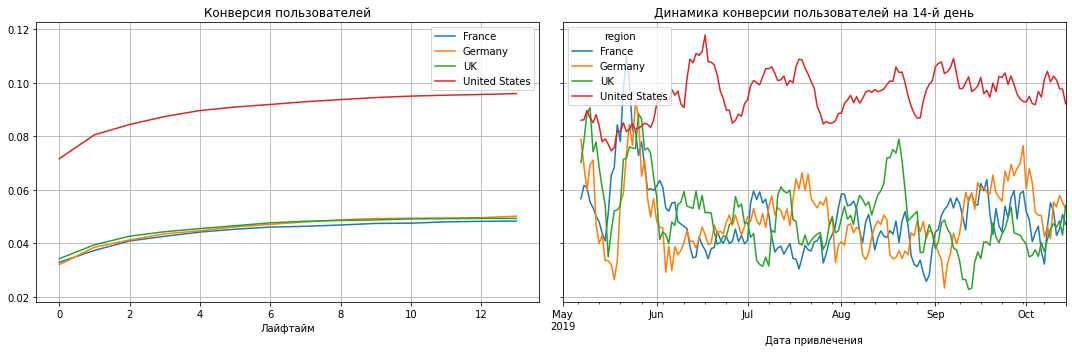

In [73]:
plot_conversion(conversion, conversion_history, horizon, window=7)

*В разы лучше других конвертируются пользователи в США.*

#### Посмотрим, как обстоят дела с удержанием пользователей:

In [74]:
result_raw, retention, retention_history = get_retention(
    profiles_ad,
    visits,
    observation_date,
    horizon,
    dimensions=[],
    ignore_horizon=False,
)

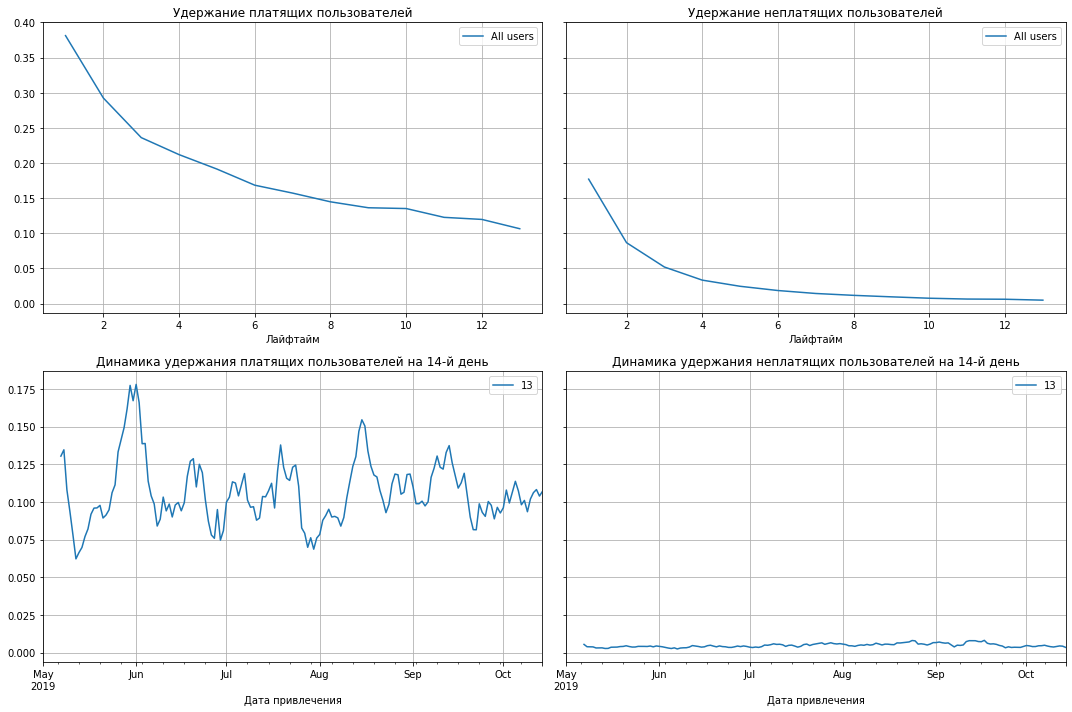

In [75]:
plot_retention(retention, retention_history, horizon, window=7)

*С удержанием пользователей тоже всё выглядит стабильно. Платные пользователи удерживаются в разы лучше не платящих.*

#### Посмотрим на показатель удержания в разрезе канала:

In [76]:
result_raw, retention, retention_history = get_retention(
    profiles_ad,
    visits,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False,
)

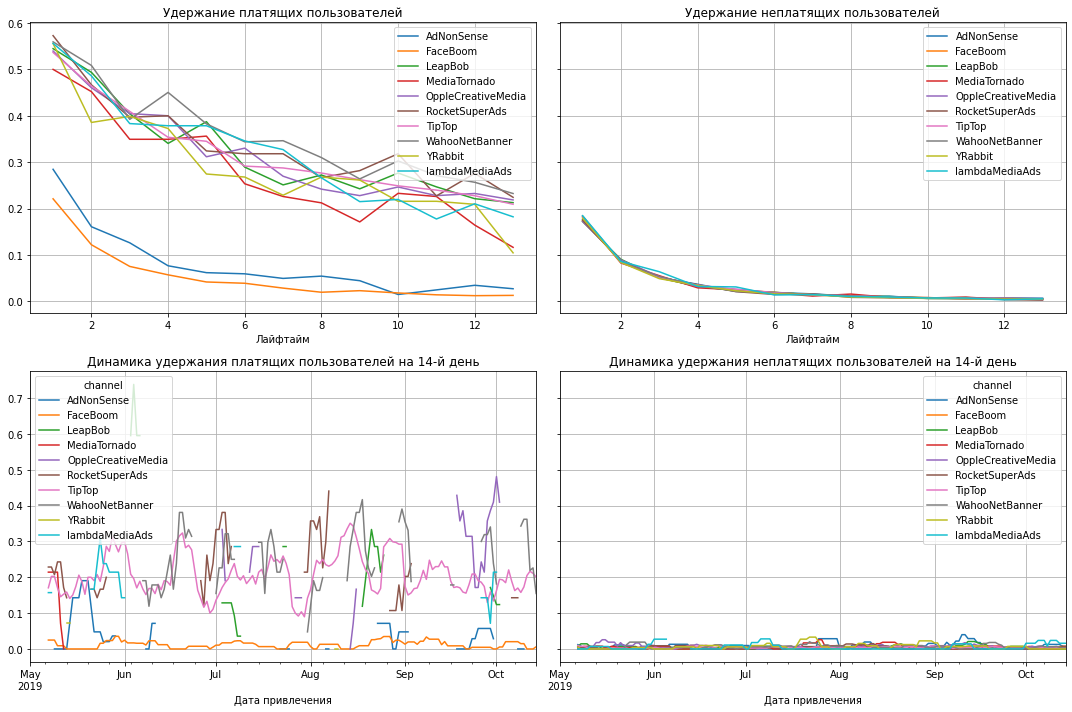

In [77]:
plot_retention(retention, retention_history, horizon, window=7)

*Мы видим, что пользователи в каналах FaceBoom и AdNonSense удерживаются намного хуже, чем в других каналах. Также держим в уме, что на  FaceBoom тратиться ~ 30% всего маркетинга.*

#### Посмотрим, как удерживаются пользователи с разных устройств:

In [78]:
result_raw, retention, retention_history = get_retention(
    profiles_ad,
    visits,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False,
)

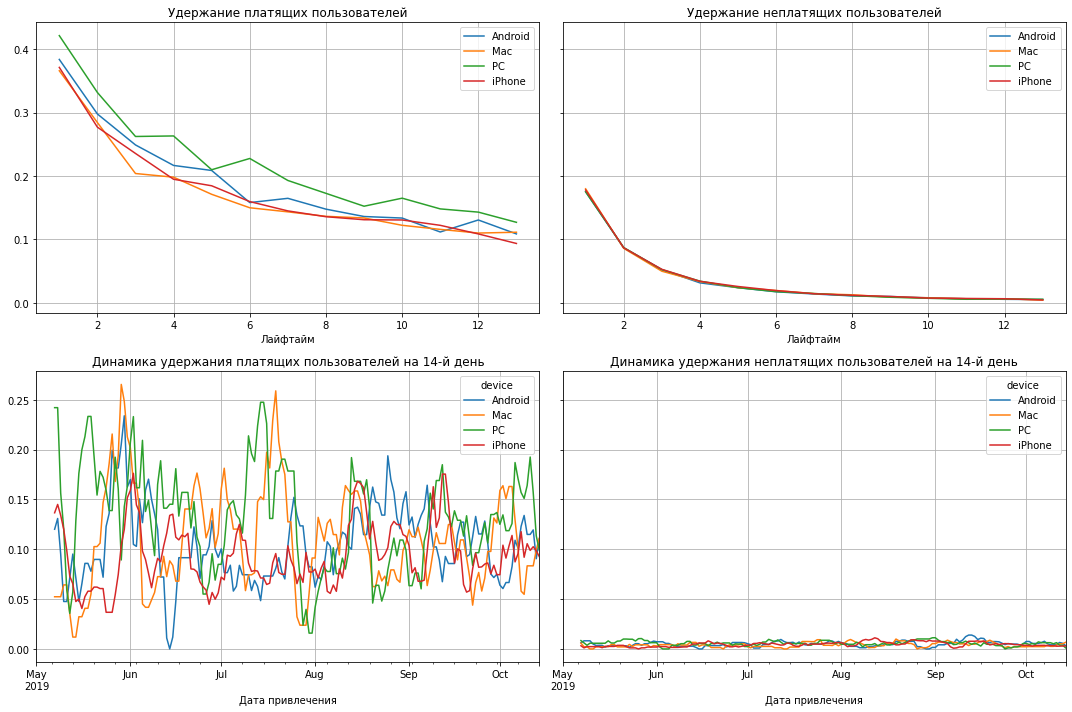

In [79]:
plot_retention(retention, retention_history, horizon)

*Здесь не видим больших перекосов. Чуть лучше других удерживаются пользователи с PC, при том, что конверсия у них наименьшая.*

#### Посмотрим на удержание в разрезе стран:

In [80]:
result_raw, retention, retention_history = get_retention(
    profiles_ad,
    visits,
    observation_date,
    horizon,
    dimensions=['region'],
    ignore_horizon=False,
)

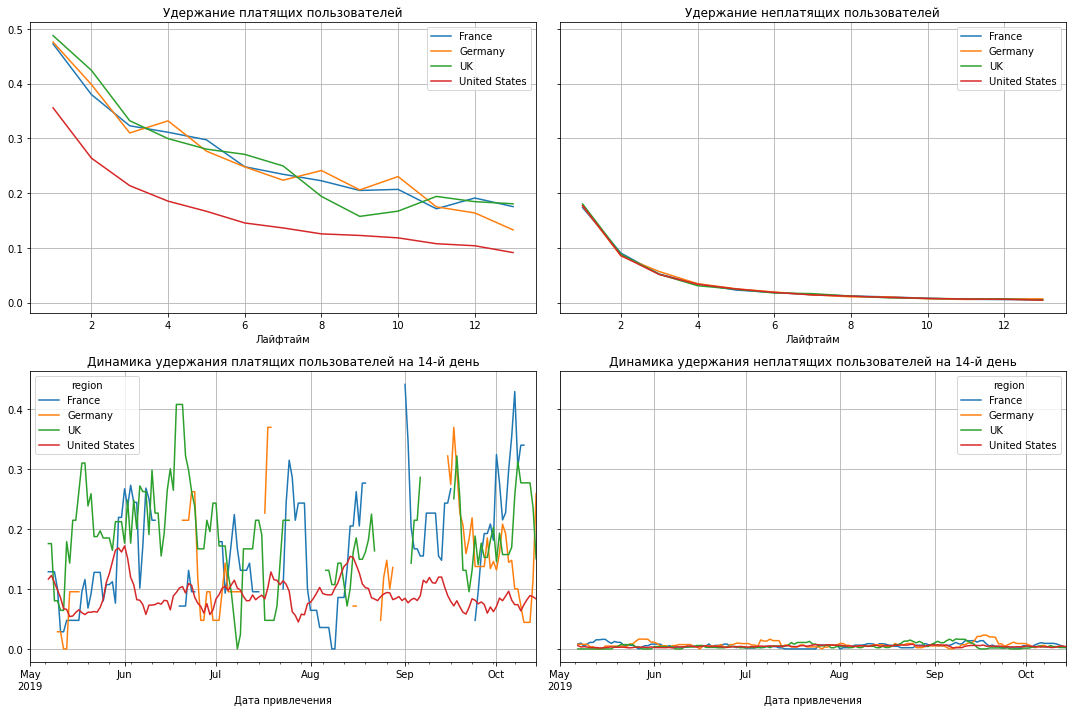

In [81]:
plot_retention(retention, retention_history, horizon, window=7)

*Обращаем внимание, что хуже всего удерживаются пользователи из США.*

**Проверив конверсию и удержание, мы обратили внимание на каналы FaceBoom и ADNonSense, которые имеют самые низкие показатели удержания, а также на регион США, который имеет самый низкий показатель удержания при самой высокой конверсии. Проверим теперь LTV и ROI по тому же принципу.**  

#### Проанализируем показатели и динамику  LTV   и  ROI   по устройствам:

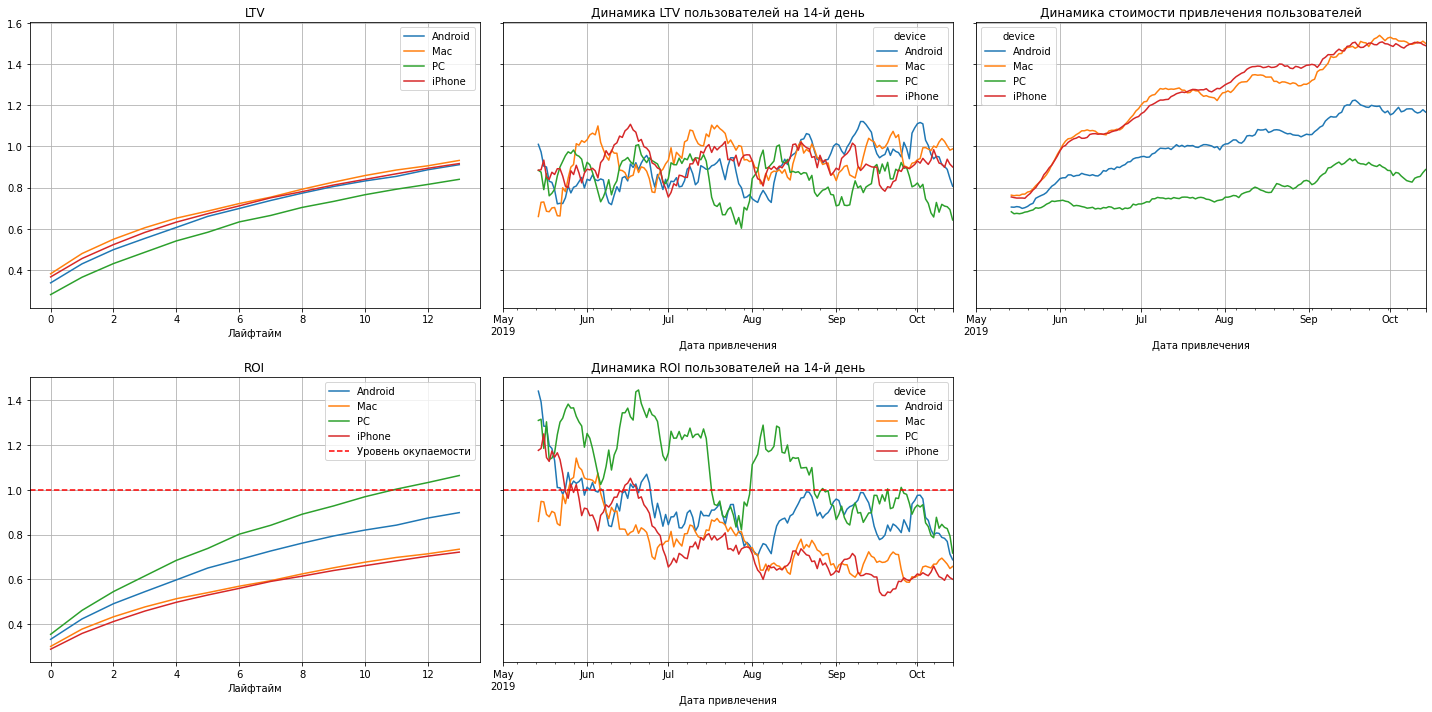

In [55]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*Мы видим, что устройства Iphone и Mac не выходят на окупаемость и также видим, что стоимость привлечения пользователей с этих устройств выросла больше всего. Держим в уме, что с этих устройств привлекается больше всего платных пользователей. Также видим, что по всем устройствам ROI к концу периода ниже порога окупаемости, при этом CAC максимальный у всех, кроме PC (и это устройство единственное, которое выходит на окупаемость) - что лишний раз подтверждает нашу гипотезу о том, что расходы на рекламу стоит пересмотреть.*  

#### Посмотрим на такие же показатели в разрезе стран: 

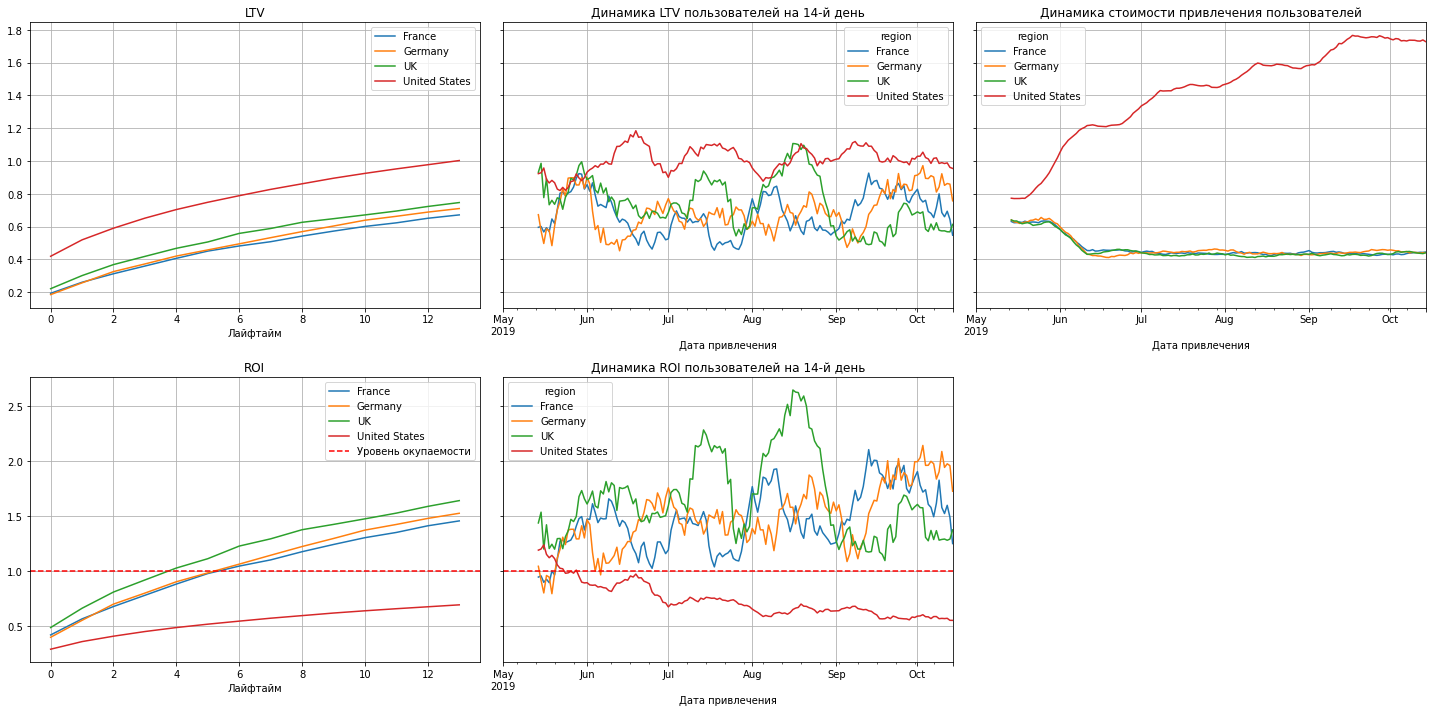

In [56]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['region'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*Здесь мы видим, что на окупаемость в Великобритании, Германии и Франции уходит менее 6 дней, что является хорошим показателем. При этом продвижение в США совсем не окупается. Также можно отметить, что реклама в США окупалась до резкого роста САС. Вот мы и определили проблемный регион, который в тоже время приводит наибольшее количество пользователей, но хуже всего их удерживает.*  

#### Теперь посмотрим на показатели в разрезе каналов продвижения:

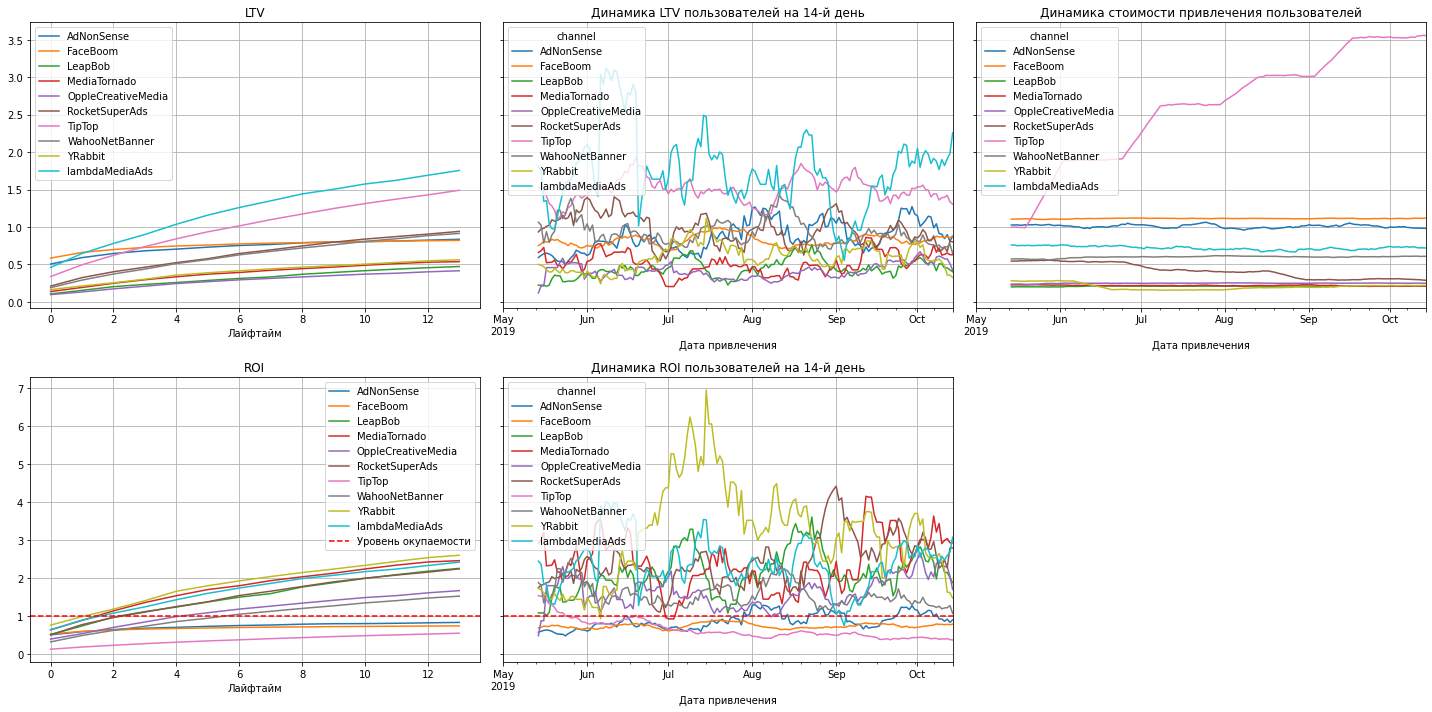

In [57]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ad,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*По графикам видим, что реклама не окупается в 3-х источниках: FaceBoom, AdNonSense и TipTop (при этом мы помним, что FaceBoom привлекает наибольшее количество пользователей, но хуже всего их удерживает,  а на TipTop уходит более 50% всех расходов на маркетинг и его стоимость к концу периода выросла более, чем в 3 раза). Можем отметить, что самую высокую окупаемость имеет канал YRabit, при этом он занимает последнее место в статье расходов и имеет один из самых низких показателей стоимости на одного привлеченного пользователя.*

**Итак, мы опредили проблемный регион - США, устройства - IPhone, Mac, Android,  каналы - AdNonSense, FaceBoom, TipTop.**

#### Посмотрим на метрики в разрезе проблемного региона:

In [58]:
profiles_problem = profiles_ad.query('region == "United States"')

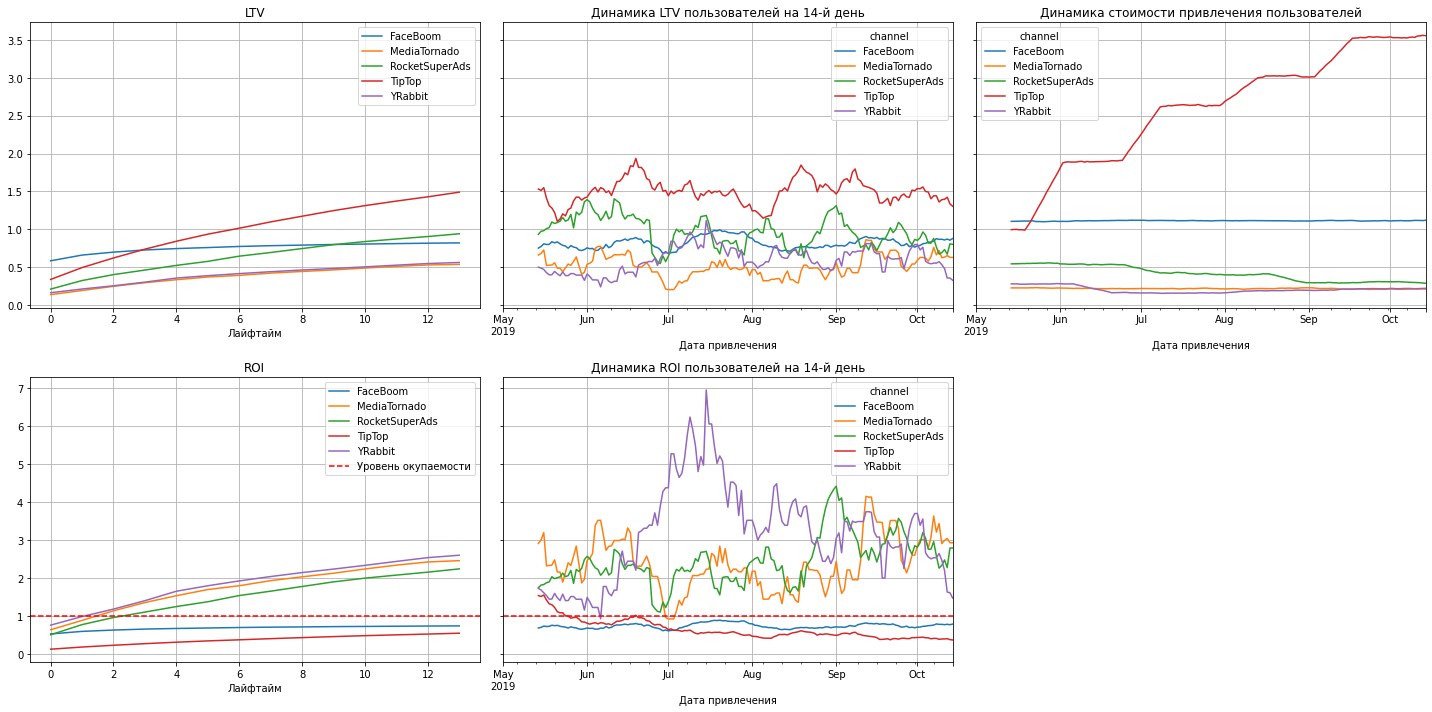

In [59]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_problem,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*Обращаем внимание, что два самых дорогих канала FaceBoom и TipTop  одновременно самые убыточные (хотя какнал TipTip окупался пока стоимость привлечения одного пользователя в нем была на уровне 1$). При этом самый дешевый канал YRabbit является самым окупаемым. Вероятно иммет смысл пересмотреть расходы в сторону более дешевых каналов продвижения* 

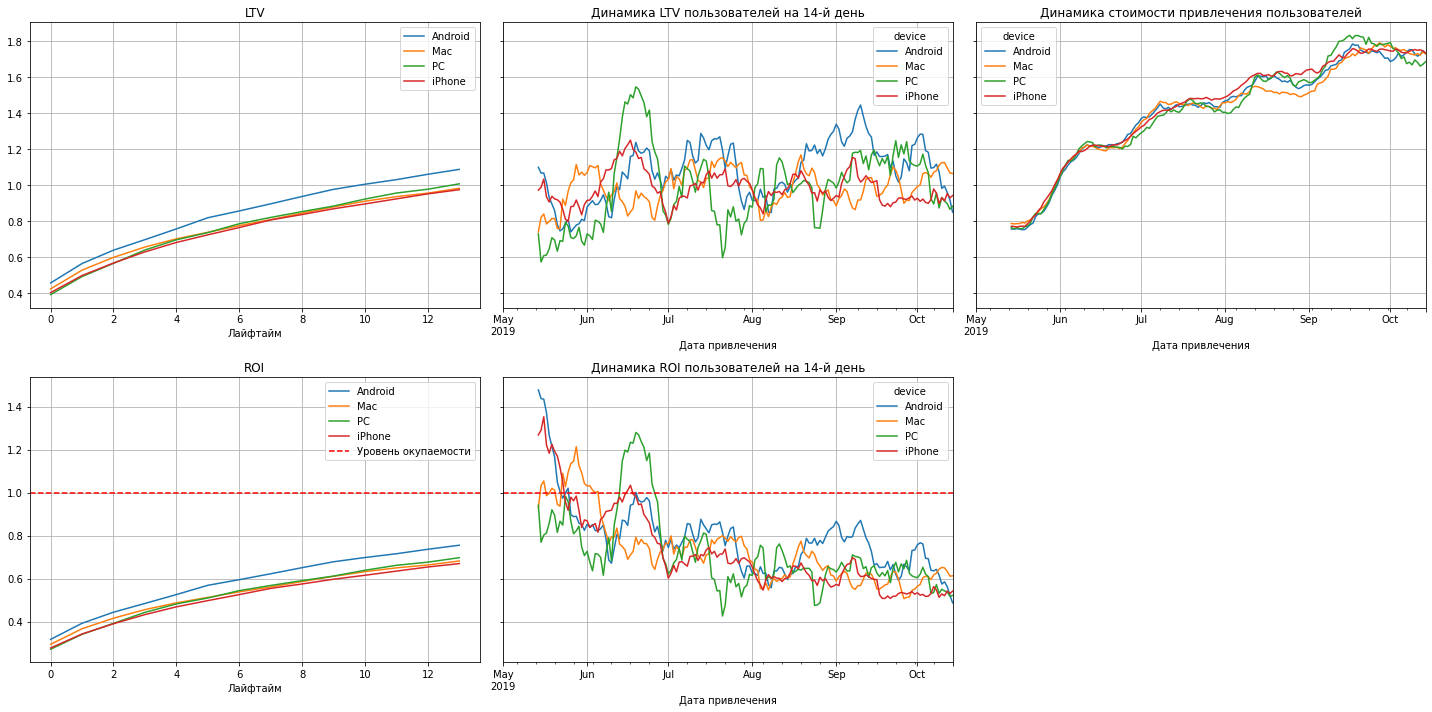

In [60]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_problem,
    orders,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*Что касается устройств, то реклама на всех устройствах в США не окупается. Вероятно здесь стоит смотреть пункт выше. Два нерентабельных канала продвиженя вероятно влияют на всю картину по региону. C TipTop мы выяснили, что стоимость привлечения пользователей в нем выросла в разы и он стал неокупаемым, а FaceBoom имеет плохой показатель удержания пользователей.*

#### Проанализируем также картину в остальных регионах, кроме США:

In [61]:
profiles_problem = profiles_ad.query('region != "United States"')

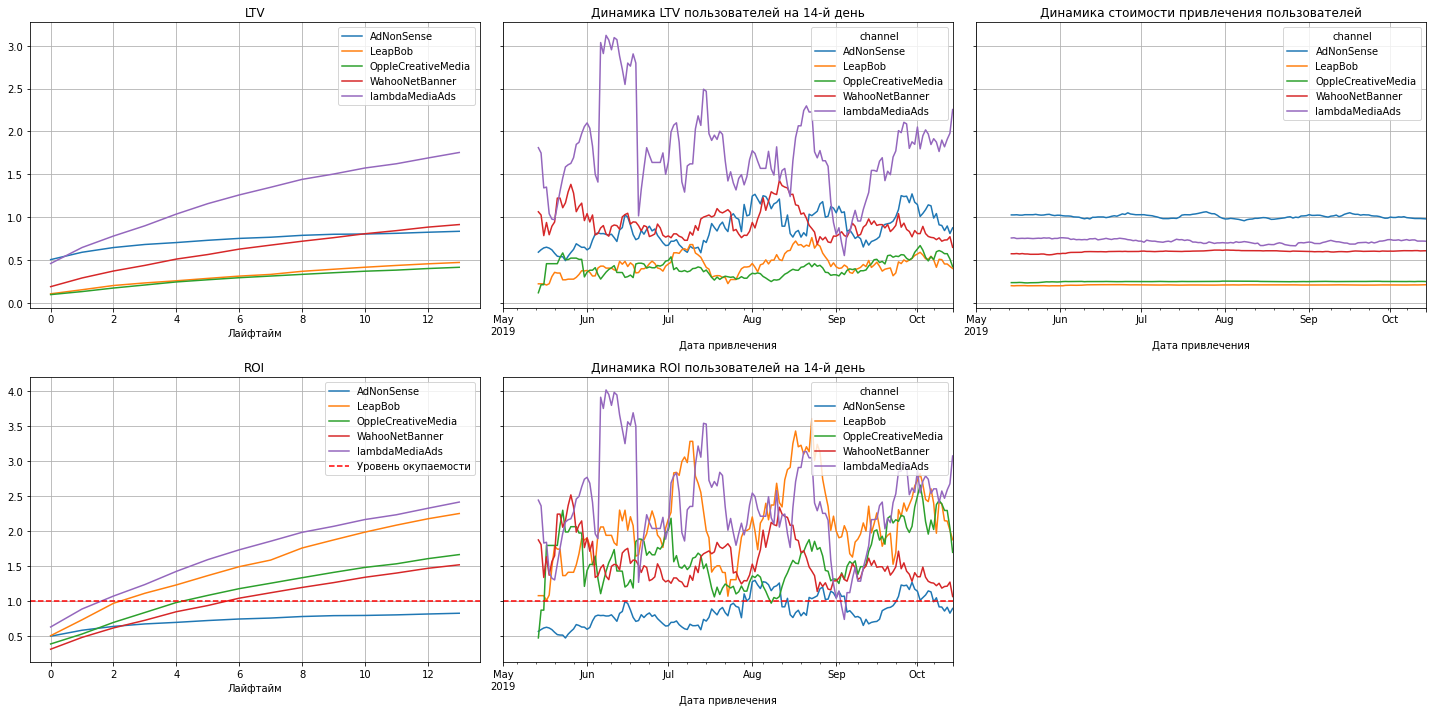

In [62]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_problem,
    orders,
    observation_date,
    horizon,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*Здесь можем отметить канал AdNonSense, который не выходит на окупаемость имеет плохой по сравнению с остальными показатель удержания.  Вероятно имеет смысл перераспределить расходы с него на каналы, которые очень быстро выходят на окупаемость: lamdaMediaAds и LeapBob.*

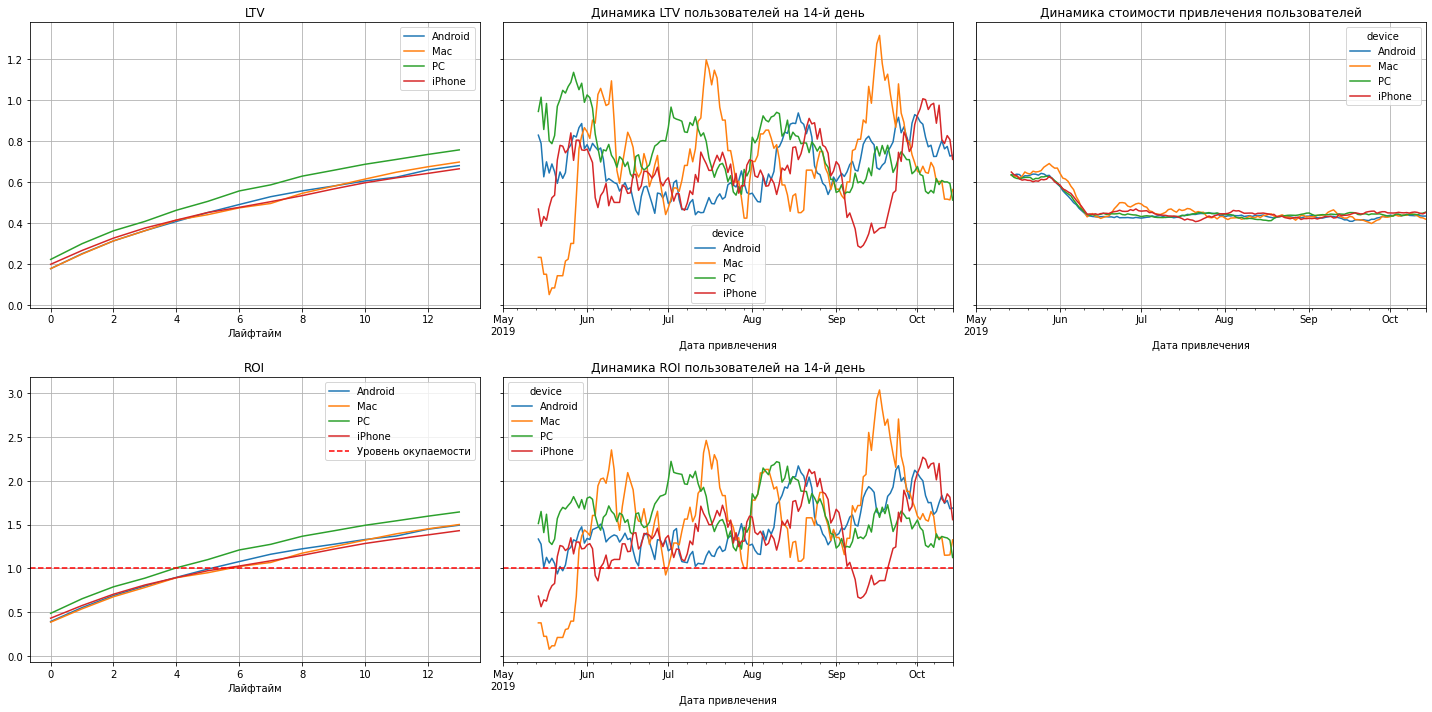

In [63]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_problem,
    orders,
    observation_date,
    horizon,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14)

*По устройствам все вложения в  Европе окупаются, при этом PC имеет лучший показатель.*

**Итак, мы выяснили, что на общую картину эффективности рекламы влияет в первую очередь убытьчность региона США. Также определили, что убыточность региону США приносят два нерентабельных канала продвижения FaceBoom и TipTop. В Европе показатели снижает лишь один убыточный канал продвижения  AdNonSense и на общую картину это практически не влияет.**

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### **Мы провели анализ эффектиивности рекламной кампании приложения и выяснили основные причины убыточности кампании:**

##### Рекламная компания убыточна на всех устройствах в регионе США;

##### ~ 83% всех расходов на маркетинг были направлены в дорогостоящие каналы продвижения в США, которые не окупаются - FaceBoom и TipTop;

##### При этом на каналы с высокой скоростью возврата инвестиций в США было направлено лишь ~ 2% всех расходов.

##### Продвижение в Европе неэффективно только в одном канале продвижения - AdNonSense.  

#### **Рекомендации для отдела маркетинга:**

#####  По итогам анализа рекламный канал FaceBoom не выходит на окупаемость, при этом показатель ниже уровня окупаемости стабилен на протяжении всего периода. И, хотя канал привлекает наибольшее количество пользователей, качество этих пользователей оставляет желать лучшего, так как показатель удержания  находится на самом низком уровне среди всех каналов. Имеет смысл провести дополнительный анализ причин низкого уровня удержания пользователей - возможно  имеет место быть какая-то техническая ошибка, которую можно исправить и вывести канал на окупаемость. В ином случае рекомендуется перераспределить расходы с этого канала на более эффективные. 

##### Рекламный канал TipTop является самой дорогостоящей убыточной инвестицией. Рекомендуется сократить расходы на данный канал продвижения до уровня мая 2019 года или ниже и по итогу провести повторный анализ по его окупаемости. 

##### Освободившийся бюджет с канала TipTop рекомендуется перераспределить в сторону высокоокупаемых каналов продвижения YRabbit и  MediaTornado. 

#### В Европейском направлении  рекомендуется поработать c каналом продвижения ADNonSense  - либо дополнительно проанализировать причины низкого уровня удержания пользователей, либо еще снизить расходы на него и перераспределить  их в сторону окупаемых каналов продвижения  lamdaMediaAds и LeapBob.